Tutorial 3: Inversions

We’ve covered Mapper’s, which, if I haven’t emphasised it enough yet, map things. Now, we’re going to look at how we can use these Mapper’s (which map things) to reconstruct the source galaxy - I hope you’re excited!

In [34]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt
from pyprojroot import here
import numpy as np

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/autolens_workspace


We’ll use the same strong lensing data as the previous tutorial, where:

    The lens galaxy’s light is omitted.
    The lens galaxy’s MassProfile is an PointMass2.
    The source galaxy’s LightProfile is an EllipticalSersic.


In [35]:
dataset_path = f"{workspace_path}/howtolens/PointMass2/Data"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/MGEimage.fits",
    noise_map_path=f"{dataset_path}/MGEnoise_map.fits",
    psf_path=f"{dataset_path}/MGEpsf.fits",
    pixel_scales=0.1,
)


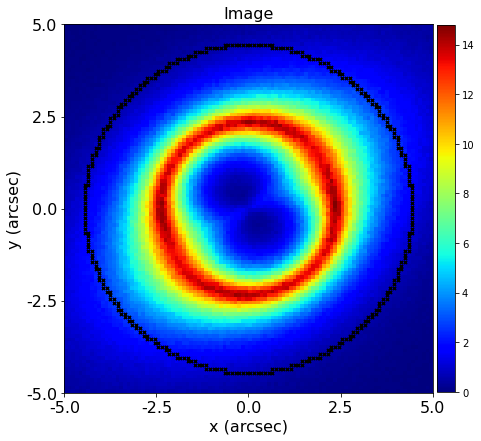

In [41]:
mask = al.Mask.circular(
    shape_2d=imaging.shape_2d,
    pixel_scales=imaging.pixel_scales,
    radius=4.5,
)


aplt.Imaging.image(imaging=imaging, mask=mask)

Next, lets set the Imaging and Mask up as a MaskedImaging object and setup a Tracer using the input lens galaxy model (we don’t need to provide the source’s LightProfile, as we’re using a Mapper to reconstruct it).

In [42]:
#Parâmetros do MGE
Surf_mge, sigma, qObs = np.loadtxt('/home/carlos/Documents/Dados Projeto/ESO325/Results/ESO325 MGE and JAM (07-07-20)/Codes/JAM Input.txt', unpack=True)

ML = 3.14
i = np.deg2rad(80)
M0 = Surf_mge*ML/1e4
M0 = M0[::-1]
q0 = np.sqrt(qObs**2 - np.cos(i)**2)/np.sin(i)
sigma0 = sigma

In [43]:
masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)
mass_profile = al.mp.MGE(centre=(0.0,0.0), einstein_radius=1.6)
mass_profile.MGE_comps(M=M0, sigma=sigma0, q=q0)

lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=mass_profile,
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=1.0)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]


We’ll use another rectangular Pixelization and Mapper to perform the reconstruction.

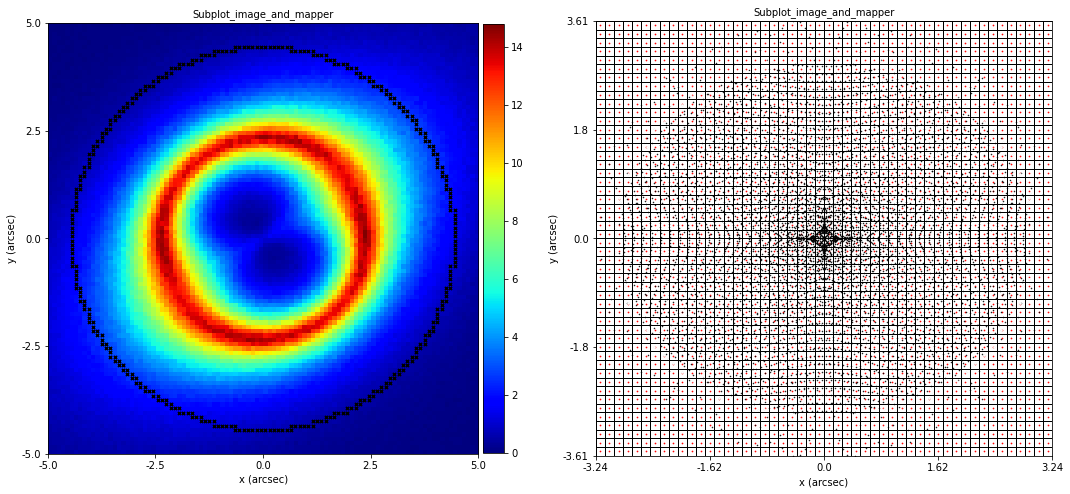

In [44]:
rectangular = al.pix.Rectangular(shape=(50, 50))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
)

And now, finally, we’re going to use our Mapper to invert the image using an Inversion. I’ll explain how this works in a second - but lets just go ahead and use the Inversion first. (Ignore the ‘regularization’ input below for now, we’ll cover this in the next tutorial).

In [45]:
inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=1.0),
)

Our Inversion has a reconstructed image and Pixeilzation, which we can plot using an Inversion plotter

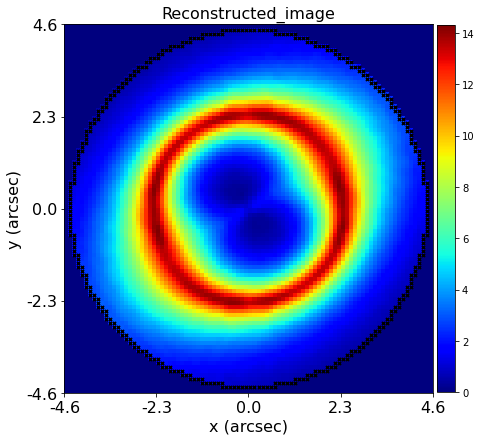

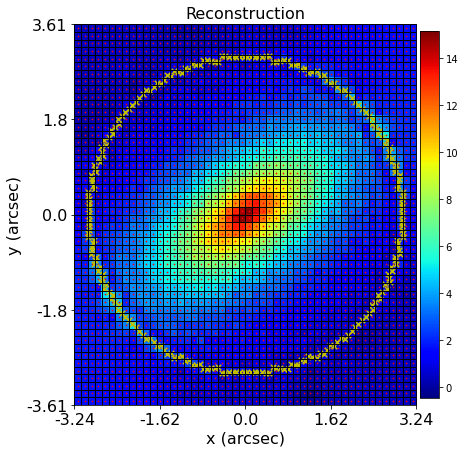

<Figure size 432x288 with 0 Axes>

In [46]:
aplt.Inversion.reconstructed_image(inversion=inversion, include=aplt.Include(mask=True))

aplt.Inversion.reconstruction(
    inversion=inversion, include=aplt.Include(inversion_grid=False)
)
import matplotlib.pyplot as plt
plt.savefig('Inversion.png')

Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


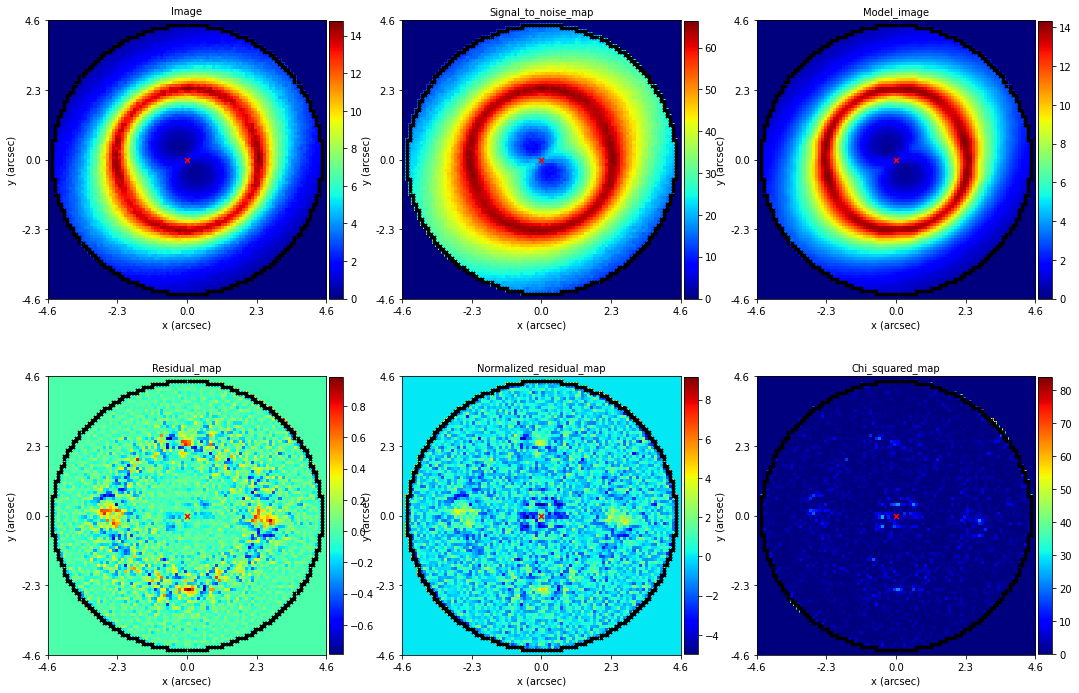

In [47]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.0),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))

